### Introduction

In this project, we'll be working with the [Chinook](https://github.com/lerocha/chinook-database) database. This database has sales information for the Chinook record store. We'll be working on answering various business questions of increasing complexity and retrieving the results using sqlite in conjunction with Python to query the results.

We'll begin by making some helper functions that will allow us to communicate with our databse.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
import sqlite3
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command():
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute

def show_tables():
    q = '''
        SELECT
                name,
                type
        FROM sqlite_master
        WHERE type in ("table", "view")'''
    return run_query(q)
    

list_tab = show_tables()
print(list_tab)

              name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table


The first question we wish to ask is what genre of album would generate the most sales if purchased by the store. To that end, we'll create a query to return a table of music genres organized by percentage of total sales. We'll create a graph of the distribution for easier visualization.

In [2]:
q = '''
WITH usa_tracks AS
(
    SELECT il.* FROM invoice_line AS il
    INNER JOIN invoice AS i ON il.invoice_id = i.invoice_id
    INNER JOIN customer AS c ON i.customer_id = c.customer_id
    WHERE c.country = "USA"
)

SELECT 
    g.name genre,
    COUNT(usat.invoice_line_id) tracks_sold,
    CAST(COUNT(usat.invoice_line_id) as FLOAT)/(
    SELECT COUNT(*) FROM usa_tracks) percentage
    FROM usa_tracks AS usat
    INNER JOIN track AS t ON t.track_id = usat.track_id
    INNER JOIN genre AS g ON g.genre_id = t.genre_id
    GROUP BY 1
    ORDER BY 2 DESC
'''
run_query(q)

,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


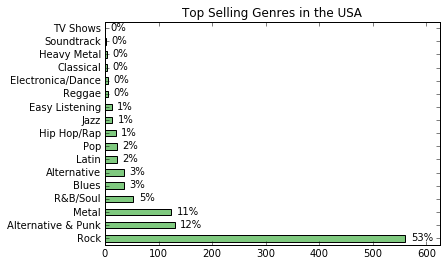

In [3]:
q1_df = run_query(q)
q1_df.set_index('genre', inplace = True, drop = True)

q1_df['tracks_sold'].plot.barh(
    title = "Top Selling Genres in the USA",
    xlim = (0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(q1_df.index)):
    score = q1_df.loc[label, "tracks_sold"]
    label = (q1_df.loc[label, 'percentage']*100).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i- 0.15))
    
plt.show()

Looking at the visualization of our data, we would ideally want to put out records in the three most popular genres available. Thus we wish to select which of Hip-Hop, Punk, Pop, and Blues have had the best track sales recently from the data available to us. From the bar chart we can see that the Alternative & Punk category and Blues category are significantly more popular than the Hip-Hop and Pop genres, in terms of sales. Thus we would suggest adding the records of Red Tone and Slim Jim Bites to the store for sure, along with one of Regal or Meteor and the Girls. As both genres have similar sales numbers, the choice of the third group is not overly consequential.

Next, we wish to take a look at sales employee performance in relation to their seniority.

In [4]:
q2 = '''
SELECT 
e.first_name || ' ' || e.last_name employee_name,
e.hire_date hire_date,
TOTAL(i.total) AS total_sales
FROM employee AS e
INNER JOIN customer AS c ON e.employee_id = c.support_rep_id
INNER JOIN invoice AS i ON i.customer_id = c.customer_id
WHERE e.title = "Sales Support Agent"
GROUP BY 1
'''

run_query(q2)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


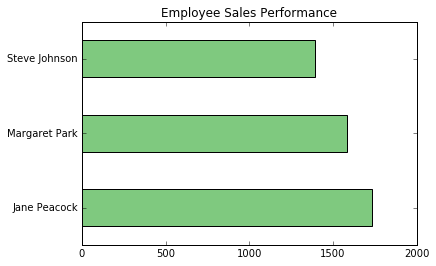

In [5]:
q2_df = run_query(q2)
q2_df.set_index('employee_name', inplace = True, drop = False)

q2_df.plot.barh(
    title = 'Employee Sales Performance',
    xlim = (0, 2000),
    colormap = plt.cm.Accent,
    legend = False
)

plt.ylabel('')
plt.show()

Observing the table returned from the query and the bar graph, we can see that the total sales increase the earlier the Sales Support Agent was hired. This is a fairly logical correlation, as an employee hired earlier would have both more experience and more time to accrue sales as opposed to their less experienced colleagues.

Next we'll take a look at customer base sorted by country. The goal here is to look for potential new markets to advertise in.

In [6]:
q3 = '''
WITH sub_inv AS 
(
    SELECT
        CASE
            WHEN (
                SELECT COUNT(*)
                FROM customer
                WHERE country = c.country
                ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*    
    FROM invoice_line AS il
    INNER JOIN invoice AS i ON il.invoice_id = i.invoice_id
    INNER JOIN customer AS c ON c.customer_id = i.customer_id
)

SELECT 
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
        SELECT
            country,
            COUNT(DISTINCT customer_id) customers,
            SUM(unit_price) total_sales,
            SUM(unit_price) / COUNT(DISTINCT customer_id) customer_lifetime_value,
            SUM(unit_price) / COUNT(DISTINCT invoice_id) average_order,
            CASE
                WHEN country = "Other" THEN 1
                ELSE 0
            END AS sort
        FROM sub_inv
        GROUP BY country
        ORDER BY sort ASC, total_sales DESC 
    );

'''

run_query(q3)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


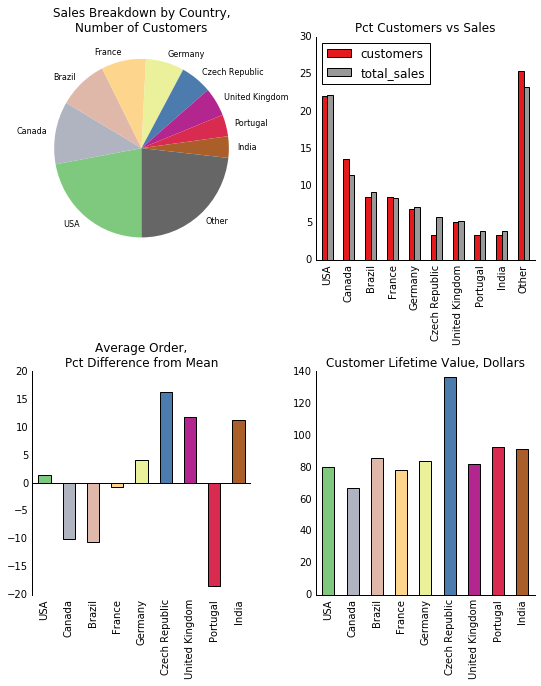

In [7]:
country_metrics = run_query(q3)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, we suspect there might be opportunities in the Czech Republic, United Kingdom and India. This is because customers from these three countries, on average, have much larger purchases than customers from other countries. It is worth noting that our sample size is relatively small. Thus, it would be unwise to overinvest in marketing campaigns as we cannot draw any sound conclusions from a data set of this size. Small, exploratory campaigns may be wise to collect more data and see if there is potential for more business.

Finally, we will take a look to see if there's any benefit to the store purchasing individual tracks as opposed to entire albums from the artist.

In [15]:
q4 = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''





run_query(q4)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

### Conclusion

In this project we worked on the Chinook database to answer a number of business related questions. We determined which albums would be potentially beneficial purchases for the store, which countries may offer potential for expanded business and whether purchasing individual tracks over entire albums might be an advantageous purchasing strategy.